# **PyTorch**

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# 1. Load SVHN Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the data
])

trainset = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
testset = datasets.SVHN(root='./data', split='test', download=True, transform=transform)

train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = DataLoader(testset, batch_size=64, shuffle=False)

100%|██████████| 182M/182M [00:06<00:00, 26.4MB/s]
100%|██████████| 64.3M/64.3M [00:02<00:00, 25.8MB/s]


In [4]:
# 2. Define the CNN Model (using PyTorch)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.fc1 = nn.Linear(128*4*4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128*4*4)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 3. Define the MLP Model (using PyTorch)
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(3*32*32, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 3*32*32)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
# 4. Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 5. Initialize Models
cnn_model = CNN().to(device)  # Initialize CNN model
mlp_model = MLP().to(device)  # Initialize MLP model

# 6. Define the Training and Evaluation Loop
def train_model(model, train_loader, test_loader, epochs=10, device='cpu'):
    model.to(device)  # Ensure the model is on the correct device
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_acc = []
    test_acc = []

    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the device

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_acc.append(train_accuracy)

        # Testing the model
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to the device
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accuracy = 100 * correct / total
        test_acc.append(test_accuracy)

        print(f'Epoch [{epoch+1}/{epochs}], Training Accuracy: {train_accuracy:.2f}%, Testing Accuracy: {test_accuracy:.2f}%')

    return train_acc, test_acc

Using device: cuda


In [6]:
# 7. Evaluate Model: Accuracy, Precision, Recall, F1, AUC, and ROC
def evaluate_model(model, test_loader, device='cpu'):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []  # To store the probabilities for AUC

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)  # Get probabilities
            _, predicted = torch.max(probs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())  # Store probabilities for AUC

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")

    # Calculate ROC for each class
    fpr, tpr, _ = roc_curve(all_labels, np.array(all_probs)[:, 1], pos_label=1)
    plt.plot(fpr, tpr, label='ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

Training CNN model...
Epoch [1/10], Training Accuracy: 74.19%, Testing Accuracy: 85.77%
Epoch [2/10], Training Accuracy: 89.33%, Testing Accuracy: 88.65%
Epoch [3/10], Training Accuracy: 91.50%, Testing Accuracy: 90.57%
Epoch [4/10], Training Accuracy: 93.14%, Testing Accuracy: 90.24%
Epoch [5/10], Training Accuracy: 94.29%, Testing Accuracy: 90.76%
Epoch [6/10], Training Accuracy: 95.36%, Testing Accuracy: 90.96%
Epoch [7/10], Training Accuracy: 96.21%, Testing Accuracy: 90.81%
Epoch [8/10], Training Accuracy: 96.97%, Testing Accuracy: 89.46%
Epoch [9/10], Training Accuracy: 97.50%, Testing Accuracy: 90.44%
Epoch [10/10], Training Accuracy: 97.89%, Testing Accuracy: 90.40%
Accuracy: 0.9040
Precision: 0.9046
Recall: 0.9040
F1 Score: 0.9040
AUC: 0.9912


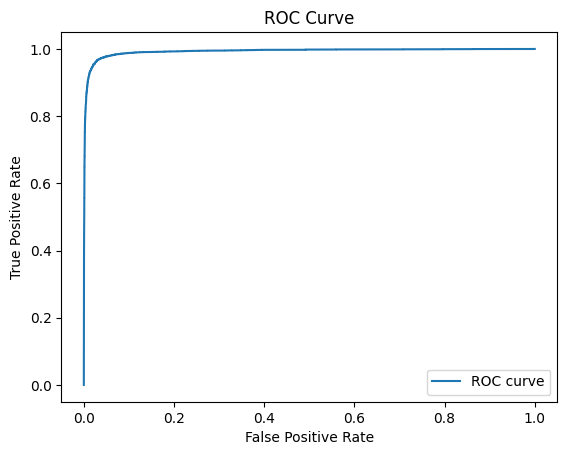

Training MLP model...
Epoch [1/10], Training Accuracy: 61.96%, Testing Accuracy: 67.39%
Epoch [2/10], Training Accuracy: 74.65%, Testing Accuracy: 74.31%
Epoch [3/10], Training Accuracy: 78.33%, Testing Accuracy: 76.08%
Epoch [4/10], Training Accuracy: 80.17%, Testing Accuracy: 76.27%
Epoch [5/10], Training Accuracy: 81.45%, Testing Accuracy: 76.29%
Epoch [6/10], Training Accuracy: 82.54%, Testing Accuracy: 77.35%
Epoch [7/10], Training Accuracy: 83.46%, Testing Accuracy: 77.34%
Epoch [8/10], Training Accuracy: 84.25%, Testing Accuracy: 78.02%
Epoch [9/10], Training Accuracy: 84.81%, Testing Accuracy: 78.13%
Epoch [10/10], Training Accuracy: 85.36%, Testing Accuracy: 76.62%
Accuracy: 0.7662
Precision: 0.7692
Recall: 0.7662
F1 Score: 0.7655
AUC: 0.9618


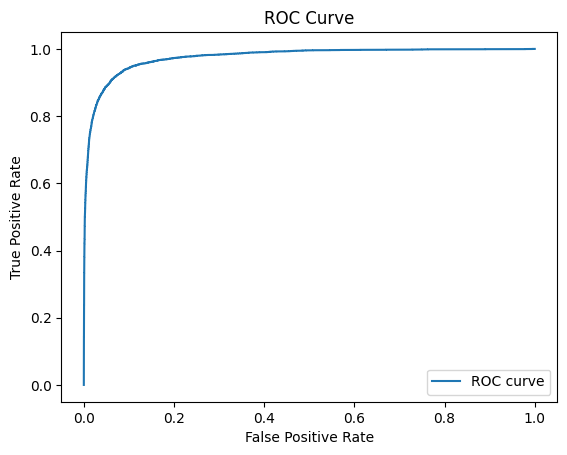

In [7]:
# 8. Train and Evaluate CNN Model
print("Training CNN model...")
cnn_train_acc, cnn_test_acc = train_model(cnn_model, train_loader, test_loader, epochs=10, device=device)
evaluate_model(cnn_model, test_loader, device=device)

# 9. Train and Evaluate MLP Model
print("Training MLP model...")
mlp_train_acc, mlp_test_acc = train_model(mlp_model, train_loader, test_loader, epochs=10, device=device)
evaluate_model(mlp_model, test_loader, device=device)

# **TensorFlow**

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

In [9]:
# 1. Load SVHN Dataset using TensorFlow
import tensorflow_datasets as tfds

# Load the SVHN dataset
train_data, test_data = tfds.load('svhn_cropped', split=['train', 'test'], as_supervised=True)

# Preprocess the data
def preprocess_data(image, label):
    image = tf.image.resize(image, (32, 32))  # Resize images to (32, 32)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize the image
    return image, label

train_data = train_data.map(preprocess_data).batch(64).prefetch(tf.data.experimental.AUTOTUNE)
test_data = test_data.map(preprocess_data).batch(64).prefetch(tf.data.experimental.AUTOTUNE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/incomplete.KKQ48V_3.1.0/svhn_cropped-train.tfrecord*...:   0%…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/incomplete.KKQ48V_3.1.0/svhn_cropped-test.tfrecord*...:   0%|…

Generating extra examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/incomplete.KKQ48V_3.1.0/svhn_cropped-extra.tfrecord*...:   0%…

Dataset svhn_cropped downloaded and prepared to /root/tensorflow_datasets/svhn_cropped/3.1.0. Subsequent calls will reuse this data.


In [10]:
# 2. Define the CNN Model (using TensorFlow/Keras)
def create_cnn_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(10, activation='softmax')  # Output layer for multi-class classification
    ])
    return model

# 3. Define the MLP Model (using TensorFlow/Keras)
def create_mlp_model():
    model = models.Sequential([
        layers.Flatten(input_shape=(32, 32, 3)),
        layers.Dense(1024, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(10, activation='softmax')  # Output layer for multi-class classification
    ])
    return model

# 4. Compile and Train the Model
def train_model(model, train_data, test_data, epochs=10):
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(train_data, epochs=epochs, validation_data=test_data)

    # Evaluate the model
    test_loss, test_acc = model.evaluate(test_data)
    print(f'Test accuracy: {test_acc:.4f}')

    return model

In [11]:
# 5. Evaluate with Metrics: Accuracy, Precision, Recall, F1, AUC, and ROC
def evaluate_model(model, test_data):
    # Predict the classes
    y_pred = model.predict(test_data)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.concatenate([y for _, y in test_data], axis=0)

    # Calculate metrics
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    auc = roc_auc_score(y_test_classes, y_pred, multi_class='ovr', average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")

    # Calculate ROC curve for each class
    fpr, tpr, _ = roc_curve(y_test_classes, np.array(y_pred)[:, 1], pos_label=1)
    plt.plot(fpr, tpr, label='ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training CNN model...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1145/1145 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - accuracy: 0.5267 - loss: 1.3859 - val_accuracy: 0.8566 - val_loss: 0.4911
Epoch 2/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.8740 - loss: 0.4277 - val_accuracy: 0.8841 - val_loss: 0.4037
Epoch 3/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.9025 - loss: 0.3295 - val_accuracy: 0.8946 - val_loss: 0.3798
Epoch 4/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.9208 - loss: 0.2727 - val_accuracy: 0.8997 - val_loss: 0.3678
Epoch 5/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.9352 - loss: 0.2250 - val_accuracy: 0.8974 - val_loss: 0.4067
Epoch 6/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.9443 - loss: 0.1912 - val_accuracy: 0.8969 - val_loss: 0.4275
Epoch 7/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.9521 - loss: 0.1621 - val_accuracy: 0.8821 - val_loss: 0.4979
Epoch 8/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.9600 - loss: 0.13

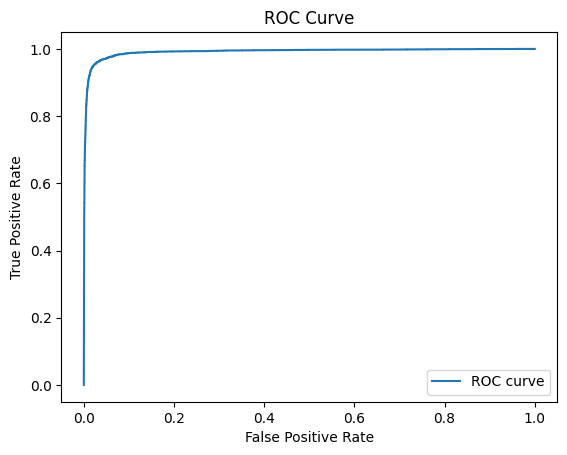

Training MLP model...
Epoch 1/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.1880 - loss: 2.3218 - val_accuracy: 0.2638 - val_loss: 2.0593
Epoch 2/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.2499 - loss: 2.0555 - val_accuracy: 0.2687 - val_loss: 2.0484
Epoch 3/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.2546 - loss: 2.0363 - val_accuracy: 0.2685 - val_loss: 2.0492
Epoch 4/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.2566 - loss: 2.0283 - val_accuracy: 0.2691 - val_loss: 2.0488
Epoch 5/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.2570 - loss: 2.0265 - val_accuracy: 0.2672 - val_loss: 2.0544
Epoch 6/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.2579 - loss: 2.0241 - val_accuracy: 0.2694 - val_loss: 2.0487
Epoch 7/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.2583 - loss: 2.0209 - val_accuracy: 0.2698 - val_loss: 2.0501
Epoch 8/10
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/ste

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


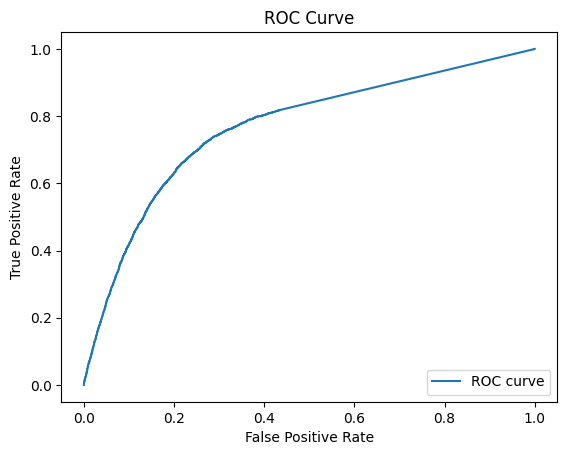

In [12]:
# 6. Initialize Models
cnn_model = create_cnn_model()
mlp_model = create_mlp_model()

# 7. Train and Evaluate CNN Model
print("Training CNN model...")
cnn_model = train_model(cnn_model, train_data, test_data, epochs=10)
evaluate_model(cnn_model, test_data)

# 8. Train and Evaluate MLP Model
print("Training MLP model...")
mlp_model = train_model(mlp_model, train_data, test_data, epochs=10)
evaluate_model(mlp_model, test_data)